# Building and Deploying a Sticker Sales Forecasting ML Solution with Modal

## Background

In January 2025, Kaggle ran a playground series [competition](https://www.kaggle.com/competitions/playground-series-s5e1/overview) to forecast multiple years' worth of sticker sales in different countries. For each id row, you have to predict the num_sold which represents the number of stickers sold for each type per store for each country.

This notebook walks through building and deploying a machine learning solution for forecasting sticker sales using [Modal](https://modal.com/) for serverless cloud computing. We'll cover the entire workflow from training to deployment.

NB: The data for this comepeition was synthentically generated but was made to contain real world patterns and effects that you might see in real data such as seasonality, weekend and holiday effect, etc.

In this project, we'll build an end-to-end solution for forecasting sticker sales across different stores and countries. We'll use:

- **XGBoost**: For the regression model
- **FastAI**: For data preprocessing
- **Modal**: For serverless compute and API hosting

The solution will allow us to:
1. Upload training data to Modal's cloud storage
2. Train a model in Modal's cloud environment
3. Deploy a prediction API endpoint
4. Make forecasts via API calls

### Evaluation

The competiton submission were evaluated on the [Mean Absolute Percentage Error (MAPE).](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) metric which expresses the average absolute error as a percentage of the actual values, making it easy to understand the relative size of errors For example, if you predict a value of 90 when the actual is 100, the percentage error is 10%, but if you predict 110 when the actual is 100, the percentage error is also 10%. MAPE averages these absolute percentage errors across all observations.

Let's get started!

### Pip install dependencies

Here we install the dependencies needed for us to run our code below

In [1]:
#| code-fold: true
#| output: false
#| code-summary: "Library Installation"


%pip install catboost
#%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
%pip install polars
%pip install tqdm
#%pip install wandb
#%pip install sweetviz
#%pip install --upgrade scipy
%pip install gradio
%pip install dash
%pip install streamlit plotly requests
%pip install boto3
%pip install modal bentoml 
%pip install streamlit pandas requests plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not wr

### Imports

In [ ]:
#|include: false 
#|hide_metadata
#| code-fold: true
#| output: false
#| code-summary: "Library Import"

import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
#from fastkaggle import setup_comp
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import VotingRegressor,StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.linear_model import LinearRegression

#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor,Pool, metrics, cv


import warnings


matplotlib.rc('image', cmap='Greys')
import scipy.stats as stats



#import h2o
#from h2o.automl import H2OAutoML

import gc
#import wandb

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

import dash
from dash import dcc, html, dash_table

import boto3
import io
import getpass
import json

from joblib import dump, load
import typing as t
import bentoml
from bentoml.validators import DataframeSchema

import modal

# Extract, Load and Transform

I use [airbyte](https://airbyte.com/) which is an open source tool that can be used to extract and load data from one source to another, building data pipelines.


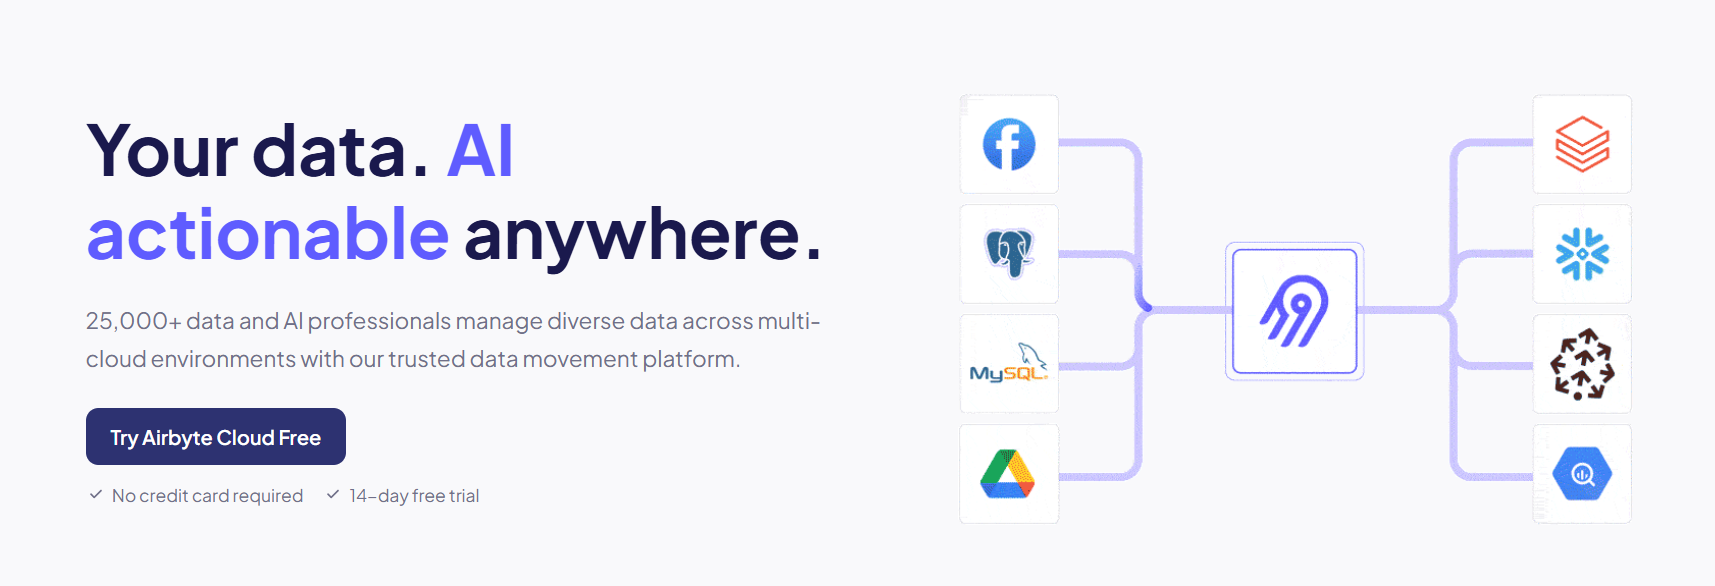


To demonstrate this in our example, we uploaded our training csv data into a google sheet and then pulled it aws s3. After this, we load this dataset into our training enviroment as shown below.

In [ ]:
#| include: false
#| code-fold: true
#| output: false
#| code-summary: "AWS Authentication"

# Get AWS credentials securely through interactive input
aws_access_key = input("Enter your AWS access key: ")
aws_secret_key = getpass.getpass("Enter your AWS secret key: ")

# Create S3 client with user-provided credentials
s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key
)

# Now you can use s3_client as before
# For example:
# response = s3_client.get_object(Bucket='your-bucket', Key='your-file.csv')
# df = pd.read_csv(io.BytesIO(response['Body'].read()))

In [ ]:
# Method 1: Download file to local and then read
#s3_client.download_file('flexible-functions', 'sticker-sales/train.csv/ss_train.csv', 'data/local_filename_ss.csv')
airbyte_df = pd.read_csv('data/local_filename_ss.csv')

Our data is in the _airbyte_data column, so lets go ahead and extract it. We have a few ways we can do this.

# Approach 1

In [ ]:
# Extract the JSON blobs from the '_airbyte_data' column
data = airbyte_df['_airbyte_data'].apply(json.loads)

# Convert the extracted JSON data into a DataFrame
extracted_df = pd.json_normalize(data)

# Save the extracted DataFrame to a CSV file in the data folder
extracted_df.to_csv("data/output.csv", index=False)
print("Data successfully extracted and saved to data/output.csv")

output_df = pd.read_csv('data/output.csv')
output_df.head()

## Approach 2 

We can load our data in a more optimal way. Lets do that below

In [ ]:
def transform_airbyte_data(input_file, output_file):
    """
    Transform Airbyte raw data format back to original tabular format
    
    Parameters:
    input_file (str): Path to the input file (CSV or JSON) from Airbyte
    output_file (str): Path to save the transformed CSV file
    
    Returns:
    pd.DataFrame: The transformed DataFrame
    """
    file_ext = os.path.splitext(input_file)[1].lower()
    
    # Read the data based on file type
    if file_ext == '.csv':
        df = pd.read_csv(input_file)
    elif file_ext == '.json':
        df = pd.read_json(input_file, lines=True)  # Assuming JSONL format
    else:
        raise ValueError(f"Unsupported file extension: {file_ext}. Use .csv or .json")
    
    # Check if the data is in Airbyte format
    airbyte_columns = [col for col in df.columns if col.startswith('_airbyte_')]
    
    if '_airbyte_data' in df.columns:
        # If *airbyte*data is a string column, parse it to dictionaries
        if df['_airbyte_data'].dtype == 'object' and isinstance(df['_airbyte_data'].iloc[0], str):
            df['_airbyte_data'] = df['_airbyte_data'].apply(json.loads)
        
        # Extract the data from *airbyte*data column
        extracted_data = pd.json_normalize(df['_airbyte_data'])
        
        # Convert numeric columns if needed
        for col in extracted_data.columns:
            if col in ['id', 'num_sold']:
                try:
                    extracted_data[col] = pd.to_numeric(extracted_data[col])
                except:
                    pass  # Keep as string if conversion fails
                    
        # Save the result
        extracted_data.to_csv(output_file, index=False)
        print(f"Transformed data saved to {output_file}")
        
        return extracted_data
    else:
        print("Data doesn't appear to be in Airbyte format. No transformation needed.")
        df.to_csv(output_file, index=False)
        return df

In [ ]:
# Example usage
if __name__ == "__main__":
    # Use paths in the data folder
    input_file = "data/local_filename_ss.csv"  # or .json
    output_file = "data/transformed_data.csv"
    
    transformed_df = transform_airbyte_data(input_file, output_file)
    transformed_df.head()

### Load data

We only did ELT job for the training dataset for demonstration, for the test and sample submission file, we shall load them from the local files.

In [ ]:
path = Path('')
path

In [ ]:
train_df = pd.read_csv(path/'data/transformed_data.csv',index_col='id')
test_df = pd.read_csv(path/'data/test.csv',index_col='id')
sub_df = pd.read_csv(path/'data/sample_submission.csv')

## Exploratory Data Analysis

In [ ]:
train_df.columns

In [ ]:
train_df.shape,test_df.shape

## Model serving and deployment with [Modal](https://modal.com/). 

Modal is a serveless cloud platform that enables us to run and execute any python code in the cloud without having to manage infrastructure.Modal makes it easy to attach GPU'S with just one line of code and can serve our functions as web endpoints.

This makes deploying ML models simple with:

- Containerized environments defined in code
- Seamless scaling
- GPU support (when needed)
- Easy endpoint creation

I previously showed how to train, serve and deploy a machine learning model to a live API endpoint with bentoml and bentocloud [here](https://nbsanity.com/static/ac40bb062434c7446906d3eb8875e061/load.html). For this project, i will be using bentoml for model management i.e. model loading and saving while i shall be running my model training, serving and endpoint deployment using Modal.

So in this project, we'll build an end-to-end solution for forecasting sticker sales across different stores and countries. We'll use:

- **XGBoost**: For training our regression model
- **FastAI**: For data preprocessing
- **Modal**: For serverless compute and API hosting

The solution will allow us to:
1. Train an XGBoost model to predict sticker sales
2. Use Modal for serverless deployment
3. Create an API endpoint for predictions
4. Visualize results with a Streamlit dashboard

Let's get started!

### Project Setup <a name="project-setup"></a>

First, we need to set up our environment. To do this, run ```modal setup``` via your terminal.

### Project Structure

Our project has this file organization:

```
retail_forecasting_model_deployment/
├── data/                           # Training and test data
├── bentofile.yaml                  # BentoML configuration
├── load_save.py                    # Local model training
├── modal_train.py                  # Modal model training
├── modal_upload.py                 # Upload data to Modal
├── modal_serve.py                  # Create API service with Modal
├── requirements.txt                # Dependencies
├── service.py                      # BentoML service definition
└── streamlit_ui/
    └── dashboard.py                # Streamlit dashboard
```

## Setting Up Your Environment

Let's start by setting up our environment:

```python
# Install required packages
!pip install modal pandas fastai xgboost bentoml scikit-learn torch streamlit plotly
```

## Understanding the Data

Our dataset contains historical sticker sales information with features like:
- Date
- Country
- Store
- Product
- Number of stickers sold (target)

```python
import pandas as pd
from pathlib import Path

# Load sample data
path = Path('data/')
train_df = pd.read_csv(path/'train.csv', index_col='id')
test_df = pd.read_csv(path/'test.csv', index_col='id')

# Display sample data
train_df.head()
```

## Data Preprocessing with FastAI

We use FastAI's tabular preprocessing to prepare our data:

```python
from fastai.tabular.all import *

# Preprocess training data
train_df = train_df.dropna(subset=['num_sold'])
train_df = add_datepart(train_df, 'date', drop=False)
test_df = add_datepart(test_df, 'date', drop=False)

# Feature preparation
cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

# Create TabularPandas processor
to = TabularPandas(train_df, 
                  procs=[Categorify, FillMissing, Normalize],
                  cat_names=cat_names,
                  cont_names=cont_names,
                  y_names='num_sold',
                  y_block=CategoryBlock(),
                  splits=splits)

# Create data loaders
dls = to.dataloaders(bs=64)
```

## Training The Model Locally

First, let's see how we'd train and save the model locally:

```python
import xgboost as xgb
import bentoml

# Prepare training data
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

# Train XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Save the model with BentoML
bentoml.xgboost.save_model("sticker_sales_v1", xgb_model)
```

## Serverless Training With Modal

Now let's look at how we can train this model in the cloud using Modal:

```python
import modal

app = modal.App("sticker-sales-forecast")
image = modal.Image.debian_slim().pip_install([
    "fastai", 
    "xgboost", 
    "bentoml", 
    "scikit-learn", 
    "pandas", 
    "numpy", 
    "torch"
])
volume = modal.Volume.from_name("sticker-data-volume")

@app.function(image=image, volumes={"/data": volume})
def train_model():
    # Set up paths
    from pathlib import Path
    path = Path('/data/')
    
    # Load data
    import pandas as pd
    print("Loading data...")
    train_df = pd.read_csv(path/'train.csv', index_col='id')
    test_df = pd.read_csv(path/'test.csv', index_col='id')
    
    # Data preprocessing
    from fastai.tabular.all import *
    print("Preprocessing data...")
    train_df = train_df.dropna(subset=['num_sold'])
    train_df = add_datepart(train_df, 'date', drop=False)
    test_df = add_datepart(test_df, 'date', drop=False)
    
    # Feature preparation
    cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
    splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
    to = TabularPandas(train_df, procs=[Categorify, FillMissing, Normalize],
                      cat_names=cat_names,
                      cont_names=cont_names,
                      y_names='num_sold',
                      y_block=CategoryBlock(),
                      splits=splits)
    dls = to.dataloaders(bs=64)
    
    # Prepare training data
    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
    
    # Train XGBoost model
    import xgboost as xgb
    import bentoml
    print("Training XGBoost model...")
    xgb_model = xgb.XGBRegressor()
    xgb_model = xgb_model.fit(X_train, y_train)
    
    # Save model with BentoML
    print("Saving model with BentoML...")
    model_tag = bentoml.xgboost.save_model(
        "sticker_sales_v1", 
        xgb_model,
        custom_objects={
            "preprocessor": {
                "cont_names": cont_names,
                "cat_names": cat_names
            }
        }
    )
    
    print(f"Model saved: {model_tag}")
    return str(model_tag)

@app.local_entrypoint()
def main():
    # Train the model remotely
    print("Starting model training on Modal...")
    model_tag = train_model.remote()
    print(f"Model training completed. Model tag: {model_tag}")
```

## Uploading Data to Modal

Before training, we need to upload our data to Modal:

```python
import modal
import sys
from pathlib import Path

# Create an app for the data upload
app = modal.App("sticker-data-upload")

# Create a volume to persist data
volume = modal.Volume.from_name("sticker-data-volume", create_if_missing=True)

@app.function(volumes={"/data": volume})
def upload_data(local_data_path):
    import shutil
    import os
    
    # Ensure the destination directory exists
    os.makedirs("/data", exist_ok=True)
    
    # Copy all files from the local data directory to the volume
    for file in Path(local_data_path).glob("*"):
        dest = f"/data/{file.name}"
        if file.is_file():
            shutil.copy(file, dest)
            print(f"Copied {file} to {dest}")
    
    # List files to confirm upload
    print("\nFiles in Modal volume:")
    for file in Path("/data").glob("*"):
        print(f" - {file}")

# Run this function to upload your data
# upload_data.remote('./data')
```

## Creating an API Service with Modal

Now let's deploy our model as an API endpoint:

```python
import modal
import pandas as pd

# Create app definition
app = modal.App("sticker-sales-api")

# Define image with specific version dependencies
base_image = (modal.Image.debian_slim()
         .pip_install("pydantic==1.10.8")        
         .pip_install("fastapi==0.95.2")         
         .pip_install("uvicorn==0.22.0")         
         .pip_install("bentoml==1.3.2")          
         .pip_install([                         
             "xgboost==1.7.6",
             "scikit-learn==1.3.1",
             "pandas",
             "numpy",
         ]))

# Create the fastai image by extending the base image
fastai_image = (base_image
                .pip_install(["fastai", "torch"]))

# Create volume to access data
data_volume = modal.Volume.from_name("sticker-data-volume")

# Simple health endpoint
@app.function(image=base_image)
@modal.fastapi_endpoint(method="GET")
def health():
    """Health check endpoint to verify the API is running"""
    return {"status": "healthy", "service": "sticker-sales-api"}

# Function to train and save model
@app.function(image=fastai_image, volumes={"/data": data_volume})
def train_xgboost_model():
    """Train an XGBoost model and return it directly"""
    import xgboost as xgb
    from fastai.tabular.all import add_datepart, TabularPandas, cont_cat_split
    from fastai.tabular.all import Categorify, FillMissing, Normalize, CategoryBlock, RandomSplitter, range_of
    from pathlib import Path
    import pickle
    import os
    
    # Create a path to save the model for future use
    model_path = "/data/sticker_sales_model.pkl"
    
    # Check if model already exists
    if os.path.exists(model_path):
        print(f"Loading existing model from {model_path}")
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        return model
    
    try:
        print("Training new model...")
        # Load and preprocess training data
        path = Path('/data/')
        
        print("Loading training data...")
        train_df = pd.read_csv(path/'train.csv', index_col='id')
        
        # Drop rows with missing target values
        train_df = train_df.dropna(subset=['num_sold'])
        
        # Add date features
        print("Preprocessing data...")
        train_df = add_datepart(train_df, 'date', drop=False)
        
        # Feature preparation
        cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
        splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
        
        # Create TabularPandas processor
        to = TabularPandas(train_df, 
                          procs=[Categorify, FillMissing, Normalize],
                          cat_names=cat_names,
                          cont_names=cont_names,
                          y_names='num_sold',
                          y_block=CategoryBlock(),
                          splits=splits)
        
        # Prepare training data
        X_train, y_train = to.train.xs, to.train.ys.values.ravel()
        
        # Train a simple XGBoost model
        print("Training XGBoost model...")
        xgb_model = xgb.XGBRegressor(n_estimators=100)
        xgb_model.fit(X_train, y_train)
        
        # Save model to file
        print(f"Saving model to {model_path}")
        with open(model_path, 'wb') as f:
            pickle.dump(xgb_model, f)
        
        print("Model training complete!")
        return xgb_model
        
    except Exception as e:
        import traceback
        print(f"Error training model: {str(e)}")
        print(traceback.format_exc())
        raise

# CSV upload endpoint 
@app.function(image=fastai_image, volumes={"/data": data_volume})
@modal.fastapi_endpoint(method="POST")
async def predict_csv(file: UploadFile = File(...)):
    """API endpoint for batch predictions from a CSV file"""
    import xgboost as xgb
    import io
    import pickle
    from fastai.tabular.all import add_datepart, TabularPandas, cont_cat_split
    from fastai.tabular.all import Categorify, FillMissing, Normalize, CategoryBlock, RandomSplitter, range_of
    from pathlib import Path
    
    try:
        # First, train or load model
        model = train_xgboost_model.remote()
        
        # Read uploaded CSV file content
        contents = await file.read()
        
        # Parse CSV data
        try:
            test_df = pd.read_csv(io.BytesIO(contents))
        except Exception as e:
            return {
                "success": False,
                "error": f"Failed to parse uploaded CSV: {str(e)}"
            }
        
        # Load the training data for preprocessing
        path = Path('/data/')
        train_df = pd.read_csv(path/'train.csv', index_col='id')
        train_df = train_df.dropna(subset=['num_sold'])
        
        # Add date features to both datasets
        train_df = add_datepart(train_df, 'date', drop=False)
        test_df = add_datepart(test_df, 'date', drop=False)
        
        # Feature preparation
        cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
        splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
        
        # Create TabularPandas processor
        to = TabularPandas(train_df, 
                          procs=[Categorify, FillMissing, Normalize],
                          cat_names=cat_names,
                          cont_names=cont_names,
                          y_names='num_sold',
                          y_block=CategoryBlock(),
                          splits=splits)
        
        # Create a test dataloader
        dls = to.dataloaders(bs=64)
        test_dl = dls.test_dl(test_df)
        
        # Make predictions using our model
        predictions = model.predict(test_dl.xs)
        
        # Return the predictions as a simple list
        return predictions.tolist()
            
    except Exception as e:
        import traceback
        return {
            "success": False,
            "error": f"Error processing CSV: {str(e)}",
            "traceback": traceback.format_exc()
        }
```

## Testing API Endpoints

Let's create a simple script to test our deployed endpoints:

```python
import requests
import json

# Your Modal API URLs (replace with your actual endpoint URLs)
HEALTH_URL = "https://flexible-functions-ai--sticker-sales-api-health.modal.run"
PREDICT_URL = "https://flexible-functions-ai--sticker-sales-api-predict-csv.modal.run"

def test_health():
    """Test the health endpoint"""
    print("\n🔍 Testing health endpoint...")
    try:
        response = requests.get(HEALTH_URL)
        if response.status_code == 200:
            print("✅ Health check successful!")
            print(f"Response: {response.json()}")
        else:
            print(f"❌ Health check failed with status code: {response.status_code}")
            print(f"Response: {response.text}")
    except Exception as e:
        print(f"❌ Error connecting to health endpoint: {e}")

def test_prediction():
    """Test the prediction endpoint with a sample CSV"""
    print("\n🔍 Testing prediction endpoint...")
    
    # Use the sample test.csv file
    try:
        files = {'file': open('data/test.csv', 'rb')}
        response = requests.post(PREDICT_URL, files=files)
        
        if response.status_code == 200:
            predictions = response.json()
            print("✅ Prediction successful!")
            print(f"Received {len(predictions)} predictions")
            print(f"First 5 predictions: {predictions[:5]}")
        else:
            print(f"❌ Prediction failed with status code: {response.status_code}")
            print(f"Response: {response.text}")
    except Exception as e:
        print(f"❌ Error connecting to prediction endpoint: {e}")

if __name__ == "__main__":
    print("=== Modal API Test ===")
    test_health()
    test_prediction()
    print("\n=== Test Complete ===")
```

## Building a Streamlit Dashboard

Finally, let's create a Streamlit dashboard to visualize our predictions:

```python
import streamlit as st
import pandas as pd
import requests
import plotly.express as px
from datetime import datetime

def load_and_predict_data(csv_path):
    """
    Sends the test CSV to the BentoML API endpoint and gets predictions
    """
    # Making a POST request to the prediction endpoint
    files = {'file': open(csv_path, 'rb')}
    response = requests.post(
        "https://flexible-functions-ai--sticker-sales-api-predict-csv.modal.run",
        files=files
    )
    predictions = response.json()
   
    # Load the original test data
    test_df = pd.read_csv(csv_path)
   
    # Add predictions to the dataframe
    test_df['predicted_sales'] = predictions
   
    # Convert date column to datetime
    test_df['date'] = pd.to_datetime(test_df['date'])
   
    return test_df

def create_dashboard():
    """
    Creates the Streamlit dashboard with enhanced filters, KPI cards, and visualizations
    """
    st.title("Sticker Sales Prediction Dashboard")
    
    # File uploader for the test CSV
    uploaded_file = st.file_uploader("Upload test CSV file", type=['csv'])
    
    if uploaded_file is not None:
        # Save the uploaded file temporarily
        with open('temp_test.csv', 'wb') as f:
            f.write(uploaded_file.getvalue())
        
        # Load data and get predictions
        df = load_and_predict_data('temp_test.csv')
        
        # Creating filters in a sidebar
        st.sidebar.header("Filters")
        
        # Time period filter
        time_periods = {
            'All Time': None,
            'Last Month': 30,
            'Last 3 Months': 90,
            'Last Year': 365
        }
        selected_period = st.sidebar.selectbox('Select Time Period', list(time_periods.keys()))
        
        # Country filter
        countries = ['All'] + sorted(df['country'].unique().tolist())
        selected_country = st.sidebar.selectbox('Select Country', countries)
        
        # Store filter
        stores = ['All'] + sorted(df['store'].unique().tolist())
        selected_store = st.sidebar.selectbox('Select Store', stores)
        
        # Product filter
        products = ['All'] + sorted(df['product'].unique().tolist())
        selected_product = st.sidebar.selectbox('Select Product', products)
        
        # Apply filters
        filtered_df = df.copy()
        
        # Apply time filter
        if time_periods[selected_period]:
            max_date = filtered_df['date'].max()
            cutoff_date = max_date - pd.Timedelta(days=time_periods[selected_period])
            filtered_df = filtered_df[filtered_df['date'] >= cutoff_date]
        
        if selected_country != 'All':
            filtered_df = filtered_df[filtered_df['country'] == selected_country]
        if selected_store != 'All':
            filtered_df = filtered_df[filtered_df['store'] == selected_store]
        if selected_product != 'All':
            filtered_df = filtered_df[filtered_df['product'] == selected_product]
        
        # Calculate metrics for KPI cards
        total_sales = filtered_df['predicted_sales'].sum()
        avg_daily_sales = filtered_df.groupby('date')['predicted_sales'].sum().mean()
        
        # Create KPI cards using columns
        col1, col2 = st.columns(2)
        
        with col1:
            st.metric("Total Predicted Sales", f"${total_sales:,.0f}")
            
        with col2:
            st.metric("Average Daily Sales", f"${avg_daily_sales:,.0f}")
        
        # Group by date and calculate daily total predicted sales
        daily_sales = filtered_df.groupby('date')['predicted_sales'].sum().reset_index()
        
        # Create the line chart using Plotly
        fig = px.line(
            daily_sales,
            x='date',
            y='predicted_sales',
            title='Predicted Daily Sales Over Time'
        )
        
        # Display the plot
        st.plotly_chart(fig, use_container_width=True)
        
        # Display detailed data view
        st.subheader("Detailed Data View")
        st.dataframe(
            filtered_df[['date', 'country', 'store', 'product', 'predicted_sales']].sort_values('date'),
            hide_index=True
        )

if __name__ == "__main__":
    # Set page configuration
    st.set_page_config(
        page_title="Sales Prediction Dashboard",
        page_icon="📊",
        layout="wide",
        initial_sidebar_state="expanded"
    )
    create_dashboard()
```

##  Deploying the Streamlit Dashboard

To deploy the Streamlit dashboard:

```bash
# Navigate to the streamlit_ui directory
cd streamlit_ui

# Run the Streamlit app
streamlit run dashboard.py
```

## Running the Entire Pipeline

Here's how to run the entire pipeline:

1. Upload data to Modal:
```bash
python modal_upload.py data/
```

2. Train the model on Modal:
```bash
python modal_train.py
```

3. Deploy the API on Modal:
```bash
python modal_serve.py
```

4. Run the Streamlit dashboard:
```bash
cd streamlit_ui
streamlit run dashboard.py
```

## Key Benefits of This Approach

1. **Serverless Training and Deployment**: Modal handles all infrastructure, scaling, and container management.

2. **Production-Ready API**: The API is automatically served with proper endpoints, error handling, and authentication.

3. **Separation of Concerns**: Data preprocessing, model training, and serving are cleanly separated.

4. **Interactive Dashboard**: Stakeholders can visualize predictions without technical knowledge.

5. **Reproducibility**: The entire pipeline is defined in code, making it easy to reproduce.

## Improvements

Feature - I shall be adding a feature store in v2 of this blog. This will help with Consistent feature engineering and avoid duplicating the same processing logic in different scripts etc.

## Conclusion

In this notebook, we've built an end-to-end machine learning system for forecasting sticker sales. We've used Modal to train and deploy our model, FastAI for preprocessing, XGBoost for prediction, and Streamlit for visualization.

This approach demonstrates how modern tools can simplify the MLOps process, reducing the overhead involved in deploying machine learning solutions to production.